# Training phase

## Setting up the configuration


In [1]:
from imgclas import config

config.print_conf_table()

group                    key                           value                         
augmentation             train_mode                    {'h_flip': 0.5, 'v_flip': 0.0, 'rot': 0.7, 'rot_lim': 30, 'stretch': 0.0, 'crop': 1.0, 'zoom': 0.2, 'blur': 0.3, 'pixel_noise': 0.3, 'pixel_sat': 0.3, 'cutout': 0.5} 

augmentation             val_mode                      {'h_flip': 0.5, 'v_flip': 0.0, 'rot': 0.5, 'rot_lim': 30, 'stretch': 0.0, 'crop': 0.9, 'zoom': 0.1, 'blur': 0.1, 'pixel_noise': 0.1, 'pixel_sat': 0.1, 'cutout': 0.0} 

---------------------------------------------------------------------------

dataset                  mean_RGB                      None            

dataset                  std_RGB                       None            

---------------------------------------------------------------------------

general                  base_directory                .               

general                  images_directory              data/images     

----------------------

## Visualizing the training results

### Display a single timestamp

Total training time: 0:21:12


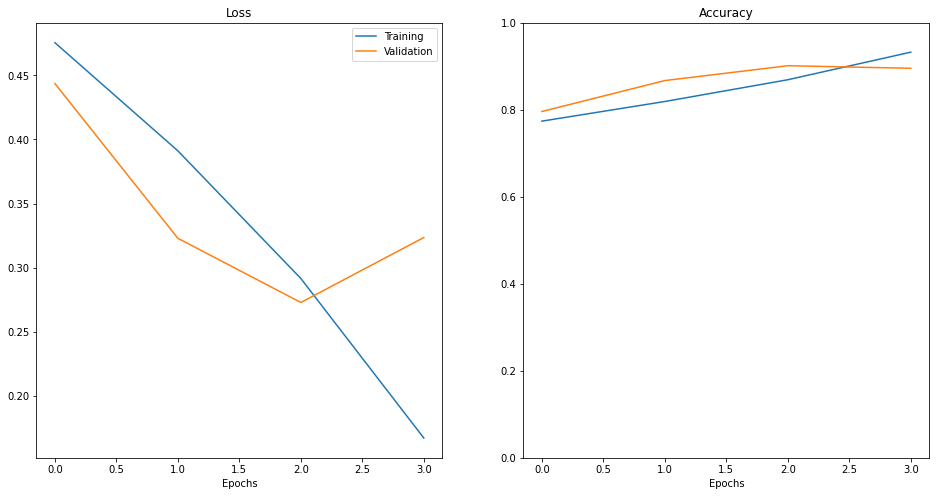

In [2]:
import os
import json
from datetime import timedelta

import matplotlib.pylab as plt
import numpy as np

from imgclas import paths, plot_utils

# User parameters to set
TIMESTAMP = '2020-05-14_163206'                       # timestamp of the model

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load training statistics
stats_path = os.path.join(paths.get_stats_dir(), 'stats.json')
with open(stats_path) as f:
    stats = json.load(f)

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)

# Plot the trainig plots 
plot_utils.training_plots(conf, stats)

# Print total training time
tr_time = int(stats['training time (s)'])
print('Total training time: {}'.format(timedelta(seconds=tr_time)))

### Compare between multiple timestamps

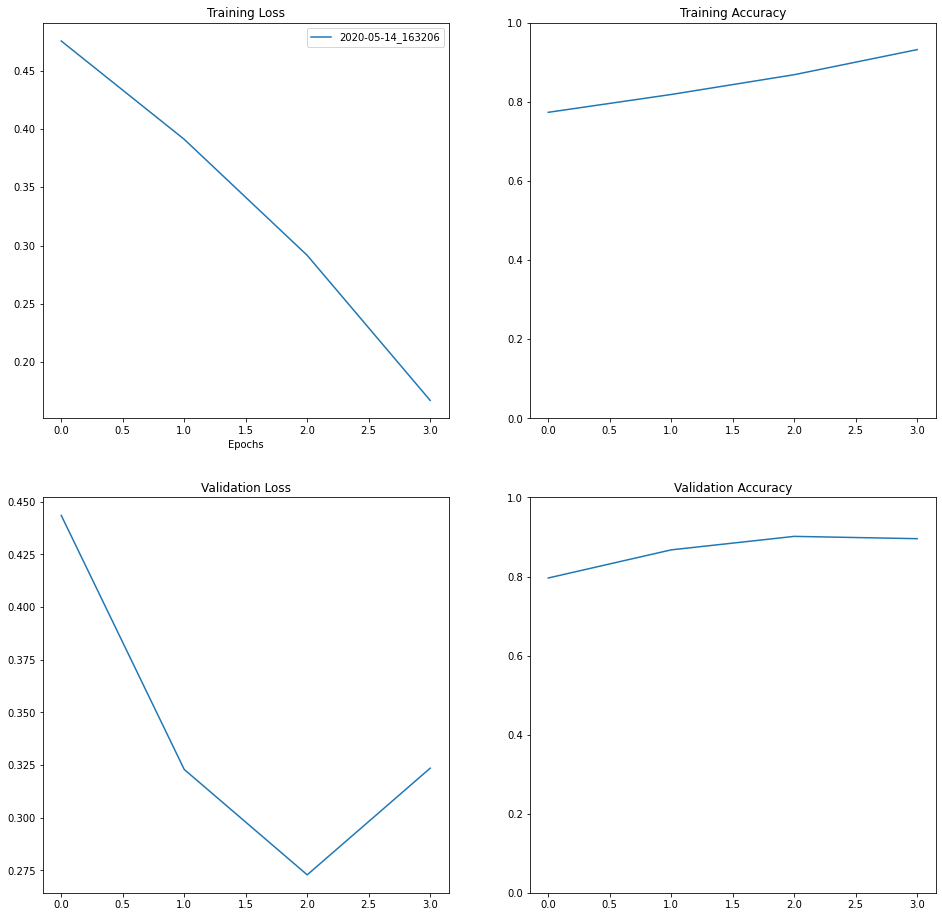

In [4]:
from imgclas.plot_utils import multi_training_plots

TIMESTAMPS = ['2020-05-14_163206',
              '2020-05-14_163206',
              '2020-05-14_163206']

multi_training_plots(timestamps=TIMESTAMPS)

# Computing the predictions

It's time to see how your net performs on unseen `test` data. We will divide the tutorial in 3 parts depending on whether you want to:
* Predict filepaths contained in a [dataset split .txt file](#Predicting-a-datasplit-txt-file)
* Predict [local images](#Predicting-local-files)
* Predict [url images](#Predicting-image-urls)

**Note** Parameters in UPPERCASE letters must be changed by the user if needed.

In [5]:
import os
import json
import numpy as np
import matplotlib.pylab as plt

from tensorflow.keras.models import load_model

from imgclas.data_utils import load_image, load_data_splits, load_class_names
from imgclas.test_utils import predict
from imgclas import paths, plot_utils, utils

# User parameters to set
TIMESTAMP = '2020-05-14_163206'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 5                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load the data
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects())

W0515 17:17:22.970000 140447852513088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0515 17:17:22.972001 140447852513088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0515 17:17:22.974011 140447852513088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Loading class names...


W0515 17:17:34.384157 140447852513088 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


## Predicting a datasplit txt file

Here we are going to compute the predictions and save them into a `.json` file to retireve them later. 

In [6]:
SPLIT_NAME = 'val'                                         # data split to use
# conf['general']['images_directory'] = '/media/ignacio/Datos/datasets/semillas/datasets/RJB'  # custom the absolute path to the images directory, if needed

# Load the data
X, y = load_data_splits(splits_dir=paths.get_ts_splits_dir(),
                        im_dir=conf['general']['images_directory'],
                        split_name=SPLIT_NAME)

# Predict
pred_lab, pred_prob = predict(model, X, conf, top_K=TOP_K, filemode='local')

# Save the predictions
pred_dict = {'filenames': list(X),
             'pred_lab': pred_lab.tolist(),
             'pred_prob': pred_prob.tolist()}
if y is not None:
    pred_dict['true_lab'] = y.tolist()

pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}+top{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path, 'w') as outfile:
    json.dump(pred_dict, outfile, sort_keys=True)

Loading val data...
1026/1026 [==============================] - 42s 41ms/step


# Predictions statistics

Let's analyse the predictions made on our test datasplit.

**Note** To run this notebook you previously have to run and save the predictions on a test dataset **with ground-truth labels**. See the Datasplit section in [3.0 notebook](./3.0-Computing_predictions.ipynb#Predicting-a-datasplit-txt-file) for reference.


In [8]:
import os
import json
import numpy as np

from imgclas.data_utils import load_image, load_class_names
from imgclas import paths, plot_utils

import warnings
warnings.filterwarnings("ignore") # To ignore UndefinedMetricWarning: [Recall/Precision/F-Score] is ill-defined and being set to 0.0 in labels with no [true/predicted] samples.

# User parameters to set
TIMESTAMP = '2020-05-13_144531'           # timestamp of the model
SPLIT_NAME = 'val'                   # dataset split to predict
MODEL_NAME = 'final_model.h5'         # model to use to make the mediction
TOP_K = 5                             # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load clas names
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}+top{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path) as f:
    pred_dict = json.load(f)

Loading class names...


## Computing the metrics

Check [sklearn](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for more classification metrics.

In [9]:
from imgclas import test_utils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


true_lab, pred_lab = np.array(pred_dict['true_lab']), np.array(pred_dict['pred_lab'])

top1 = test_utils.topK_accuracy(true_lab, pred_lab, K=1)
top5 = test_utils.topK_accuracy(true_lab, pred_lab, K=2)

print('Top1 accuracy: {:.1f} %'.format(top1 * 100))
print('Top5 accuracy: {:.1f} %'.format(top5 * 100))

labels = range(len(class_names))
print('\n')
print('Micro recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro recall (no labels): {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

print('\n')
print('Micro precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro precision (no labels): {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

print('\n')
print('Micro F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro F1 score (no labels): {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

Top1 accuracy: 90.8 %
Top5 accuracy: 100.0 %


Micro recall: 90.8 %
Macro recall: 91.0 %
Macro recall (no labels): 91.0 %
Weighted recall: 90.8 %


Micro precision: 90.8 %
Macro precision: 91.2 %
Macro precision (no labels): 91.2 %
Weighted precision: 91.4 %


Micro F1 score: 90.8 %
Macro F1 score: 90.8 %
Macro F1 score (no labels): 90.8 %
Weighted F1 score: 90.8 %


## Computing the confusion matrix

In [10]:
import matplotlib.pylab as plt
import seaborn
from sklearn.metrics import confusion_matrix

def plt_conf_matrix(conf_mat, labels=False):
    
    fig = plt.figure(figsize=(10, 10))
    hm = seaborn.heatmap(conf_mat, annot=True, square=True, cbar_kws={'fraction':0.046, 'pad':0.04}, cmap = "Blues",
                         xticklabels=labels, yticklabels=labels)
    fontsize = 14
    hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
    label_font = {'size':'18'}  # Adjust to fit
    plt.ylabel('True label', fontdict=label_font)
    plt.xlabel('Predicted label', fontdict=label_font)
    

### Standard confusion matrix

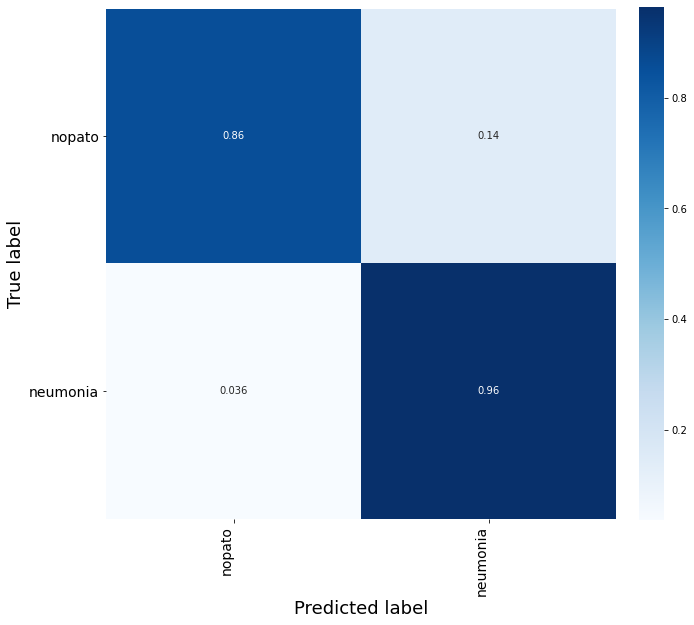

In [11]:
y_true, y_pred = np.array(pred_dict['true_lab']), np.array(pred_dict['pred_lab'])[:, 0]
conf_mat = confusion_matrix(y_true, y_pred, labels=range(len(class_names)), sample_weight=None)
normed_conf = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]

# plt_conf_matrix(conf_mat)
plt_conf_matrix(normed_conf, labels=class_names)

### Weighted confusion matrix
We weight each count in the confusion matrix by the probability of the prediction.

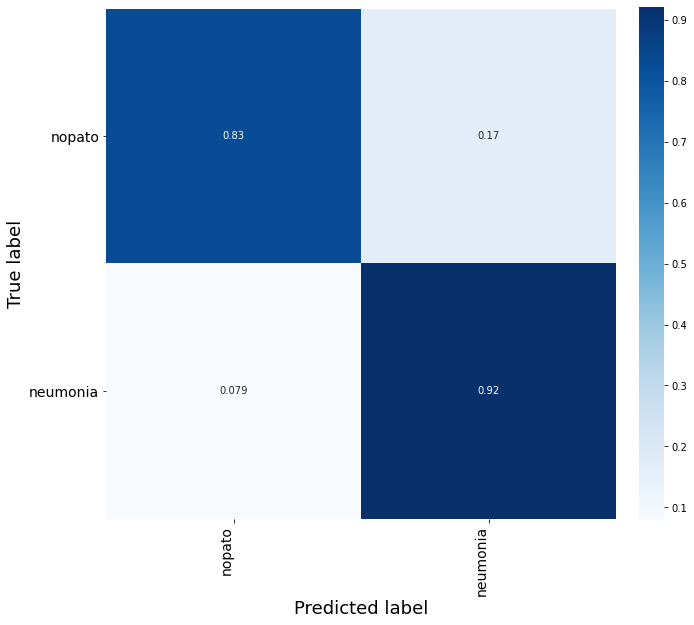

In [12]:
y_pred = np.array(pred_dict['pred_lab'])
y_true = np.repeat(np.array(pred_dict['true_lab']), y_pred.shape[1])
y_pred = y_pred.flatten()
weights = np.array(pred_dict['pred_prob']).flatten()

conf_mat = confusion_matrix(y_true, y_pred, labels=range(len(class_names)), sample_weight=weights)
normed_conf = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]

# plt_conf_matrix(conf_mat)
plt_conf_matrix(normed_conf, labels=class_names)

### List of posible colours

cmap = [Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, 
BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, 
Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, 
Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, 
PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, 
RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, 
Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, 
YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn,
autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, 
cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, 
cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r,
gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, 
gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, 
gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, 
inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r,
ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, 
rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, 
tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, 
viridis, viridis_r, vlag, vlag_r, winter, winter_r]